# Train a BNN to classify MNIST using neural SVGD

In [6]:
# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
import sys
sys.path.append("../../experiments/")
from functools import partial
from itertools import cycle

import numpy as onp
import jax
from jax import numpy as jnp
from jax import jit, grad, value_and_grad, vmap, pmap, config, random
config.update("jax_debug_nans", False)
from jax.ops import index_update, index
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import tensorflow_datasets as tfds

import haiku as hk
import optax

import nets
import utils
import models
import metrics
from convnet import model, accuracy, crossentropy_loss, log_prior, ensemble_accuracy

# Config
key = random.PRNGKey(0)
EPOCHS = 1
NUM_VALS = 20
BATCH_SIZE = 128
LEARNING_RATE = 1e-8
META_LEARNING_RATE = 1e-4
NUM_SAMPLES = 10
DISABLE_PROGRESS_BAR = False
USE_PMAP = False


if USE_PMAP:
    vpmap = pmap
else:
    vpmap = vmap

# Load MNIST
data_dir = '/tmp/tfds'
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']

# Full train and test set
train_images, train_labels = train_data['image'], train_data['label']
test_images, test_labels = test_data['image'], test_data['label']

# Split off the validation set
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=0)
data_size = len(train_images)


def make_batches(images, labels, batch_size):
    """Returns an iterator that cycles through 
    tuples (image_batch, label_batch)."""
    num_batches = len(images) // batch_size
    split_idx = onp.arange(1, num_batches+1)*batch_size
    batches = zip(*[onp.split(data, split_idx, axis=0) for data in (images, labels)])
    return cycle(batches)


def loss(params, images, labels):
    """Minibatch approximation of the (unnormalized) Bayesian
    negative log-posterior evaluated at `params`. That is,
    -log model_likelihood(data_batch | params) * batch_rescaling_constant - log prior(params))"""
    logits = model.apply(params, images)
    return data_size/BATCH_SIZE * crossentropy_loss(logits, labels) -  log_prior(params) 

# Neural SVGD Model
* Input: model parameters
* Output: 'gradient' of same shape as parameters

### Memory
Assume: BNN model has 50.000 parameters, and NSVGD layers have hidden dimensions `[1024, 1024]`. Then the NSVGD (meta) model has `2*50.000*1024` parameters (each 8 bytes), i.e. about 800MB.

The activations: `50.000 + 1024 + 1024 + 50.000` floats, i.e. about 800KB, times `NUM_SAMPLES`.

In [7]:
# Utility functions for dealing with parameters
key, subkey = random.split(key)
params_tree = model.init(subkey, train_images[:2])
params_flat, unravel = jax.flatten_util.ravel_pytree(params_tree)


def ravel(tree):
    return jax.flatten_util.ravel_pytree(tree)[0]


def init_flat_params(key):
    return ravel(model.init(key, train_images[:2]))


def get_minibatch_loss(batch):
    """
    args:
        batch = (images, labels)

    Returns a callable that computes target posterior
    given flattened param vector.
    """
    def minibatch_loss(params_flat):
        return loss(unravel(params_flat), *batch)
    return minibatch_loss


def sample_tv(key):
    """return two sets of particles at initialization, for
    training and validation in the warmup phase"""
    return vmap(init_flat_params)(random.split(subkey, NUM_SAMPLES)).split(2)


def acc(param_set_flat):
    return ensemble_accuracy(vmap(unravel)(param_set_flat),
                             val_images[:BATCH_SIZE],
                             val_labels[:BATCH_SIZE])


def vmean(fun):
    """vmap, but computes mean along mapped axis"""
    def compute_mean(*args, **kwargs):
        return jnp.mean(vmap(fun)(*args, **kwargs), axis=-1)
    return compute_mean

# init particles and dynamics model

In [8]:
key, subkey = random.split(key)
init_particles = vmap(init_flat_params)(random.split(subkey, NUM_SAMPLES))

opt = optax.sgd(LEARNING_RATE)

key, subkey1, subkey2 = random.split(key, 3)
neural_grad = models.SDLearner(target_dim=init_particles.shape[1],
                               get_target_logp=get_minibatch_loss,
                               learning_rate=META_LEARNING_RATE,
                               key=subkey1,
                               sizes=[10, 10, init_particles.shape[1]],
                               aux=False)
particles = models.Particles(subkey2, neural_grad.gradient, init_particles, custom_optimizer=opt)

# train

In [9]:
train_batches = make_batches(train_images, train_labels, BATCH_SIZE)
test_batches  = make_batches(test_images,  test_labels, BATCH_SIZE)

# Warmup on first batch
neural_grad.train(next_batch=sample_tv,
                  n_steps=100, # 100
                  early_stopping=False,
                  data=next(train_batches),
                  progress_bar=True)

100%|██████████| 100/100 [07:07<00:00,  4.27s/it]


In [10]:
def step(train_batch):
    """one iteration of the particle trajectory simulation"""
    neural_grad.train(next_batch=particles.next_batch, n_steps=10, data=train_batch)
    particles.step(neural_grad.get_params())


def evaluate(train_batch):
    test_logp = vmean(get_minibatch_loss(next(test_batches)))
    train_logp = vmean(get_minibatch_loss(train_batch))
    stepdata = {
        "accuracy": acc(particles.particles.training),
        "test_logp": test_logp(particles.particles.training),
        "training_logp": train_logp(particles.particles.training),
    }
    metrics.append_to_log(particles.rundata, stepdata)

In [11]:
num_steps = EPOCHS * data_size // BATCH_SIZE
for step_counter in tqdm(range(num_steps)):
    train_batch = next(train_batches)
    step(train_batch)
    if step_counter % (num_steps//NUM_VALS) == 0:
        evaluate(train_batch)
neural_grad.done()
particles.done()

100%|██████████| 421/421 [1:10:55<00:00, 10.11s/it]


In [12]:
particles.rundata.keys()

dict_keys(['training_mean', 'training_std', 'accuracy', 'test_logp', 'training_logp'])

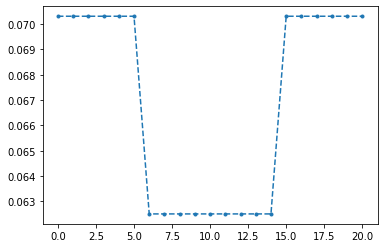

In [17]:
plt.plot(particles.rundata["accuracy"], "--.")

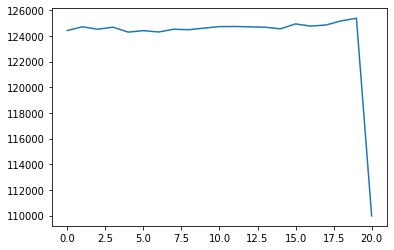

In [14]:
plt.plot(particles.rundata['training_logp'])